# Recommender Systems with Graph Neural Networks in PyG

By Derrick Li, Peter Maldonado, Akram Sbaih as part of the Stanford CS224W course project.

In this tutorial, we implement two GNN recommender system architectures, LightGCN and NGCF, in PyG and apply them to the MovieLens 100K dataset.

## Setup

First, we'll install the necessary packages.

In [26]:
# Standard library imports
import random
import time

# Third-party imports
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
import torch_geometric
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import degree

from tqdm.notebook import tqdm
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
import scipy.sparse as sp

Lastly, we should double check that our environment is working as expected.

In [27]:
torch_geometric.__version__

'2.4.0'

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Dataset and Preprocessing

For this tutorial, we’ll be using the [MovieLens 100K dataset](https://grouplens.org/datasets/movielens/), which contains 100,000 ratings by 943 users of 1682 items (movies). To ensure the quality of the dataset, each user has rated at least 20 movies.

We’ll focus on the interactions between users and items, in this case user ratings of movies, but the dataset also provides metadata about users and movies, such as user demographics and movie titles, release dates, and genres. T

The user ratings of movies form a bipartite graph, which we can apply graph machine learning methods to recommend new movies to users.


In [29]:
columns_name=['user_id','item_id','rating','timestamp']
df = pd.read_csv("./data/interim/ml-100k/u.data",sep="\t",names=columns_name)
print(len(df))
display(df.head(5))

100000


,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


We only want to use high ratings as interactions in order to predict which movies a user will enjoy watching next.

In [30]:
# How many ratings are a 3 or above?
df = df[df['rating']>=3]
print(len(df))
display(df.head(5))

82520


,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
5,298,474,4,884182806
7,253,465,5,891628467
8,305,451,3,886324817


In [31]:
# What's the distribution of highly rated movies?
print("Rating Distribution")
df.groupby(['rating'])['rating'].count()

Rating Distribution


rating
3    27145
4    34174
5    21201
Name: rating, dtype: int64

In [32]:
# Perform a 80/20 train-test split on the interactions in the dataset
train, test = train_test_split(df.values, test_size=0.2, random_state=16)
train_df = pd.DataFrame(train, columns=df.columns)
test_df = pd.DataFrame(test, columns=df.columns)

In [33]:
print("Train Size  : ", len(train_df))
print("Test Size : ", len (test_df))

Train Size  :  66016
Test Size :  16504


Since we performed the train/test randomly on the interactions, not all users and items may be present in the training set. We will relabel all of users and items to ensure the highest label is the number of users and items, respectively.

In [34]:
le_user = pp.LabelEncoder()
le_item = pp.LabelEncoder()
train_df['user_id_idx'] = le_user.fit_transform(train_df['user_id'].values)
train_df['item_id_idx'] = le_item.fit_transform(train_df['item_id'].values)

In [35]:
train_df

,user_id,item_id,rating,timestamp,user_id_idx,item_id_idx
0,770,250,5,875971902,769,249
1,169,331,5,891268491,168,329
2,327,143,4,888251408,326,142
3,85,1101,4,879454046,84,1086
4,548,264,4,891043547,547,263
...,...,...,...,...,...,...
66011,807,177,4,892705191,806,176
66012,145,12,5,882182917,144,11
66013,602,748,3,888638160,601,740
66014,622,1078,3,882671160,621,1063


In [36]:
train_user_ids = train_df['user_id'].unique()
train_item_ids = train_df['item_id'].unique()

print(len(train_user_ids), len(train_item_ids))

test_df = test_df[
  (test_df['user_id'].isin(train_user_ids)) & \
  (test_df['item_id'].isin(train_item_ids))
]
print(len(test))

943 1546
16504


In [37]:
test_df['user_id_idx'] = le_user.transform(test_df['user_id'].values)
test_df['item_id_idx'] = le_item.transform(test_df['item_id'].values)

In [38]:
n_users = train_df['user_id_idx'].nunique()
n_items = train_df['item_id_idx'].nunique()
print("Number of Unique Users : ", n_users)
print("Number of unique Items : ", n_items)

Number of Unique Users :  943
Number of unique Items :  1546


### Minibatch Sampling

Explain the scheme of minibatch positive and negative sample in some amount of prose.

We need to add `n_usr` to the sampled positive and negative items, since each node must have a unique id when using PyG.

In [66]:
def data_loader(data, batch_size, n_usr, n_itm):

    def sample_neg(x):
        while True:
            neg_id = random.randint(0, n_itm - 1)
            if neg_id not in x:
                return neg_id

    interected_items_df = data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()
    # display(interected_items_df.head(5))
    # print(len(interected_items_df))
    indices = [x for x in range(n_usr)]

    if n_usr < batch_size:
        users = [random.choice(indices) for _ in range(batch_size)]
    else:
        users = random.sample(indices, batch_size)
    users.sort()
    users_df = pd.DataFrame(users,columns = ['users'])

    interected_items_df = pd.merge(interected_items_df, users_df, how = 'right', left_on = 'user_id_idx', right_on = 'users')
    # display(interected_items_df.head(5))
    # print(len(interected_items_df))
    pos_items = interected_items_df['item_id_idx'].apply(lambda x : random.choice(x)).values
    neg_items = interected_items_df['item_id_idx'].apply(lambda x: sample_neg(x)).values

    return (
        torch.LongTensor(list(users)).to(device),
        torch.LongTensor(list(pos_items)).to(device) + n_usr,
        torch.LongTensor(list(neg_items)).to(device) + n_usr
    )

data_loader(train_df, 16, n_users, n_items)

(tensor([ 21, 169, 318, 395, 437, 499, 503, 568, 598, 630, 635, 675, 698, 821,
         838, 890], device='cuda:0'),
 tensor([1158, 1622, 1685, 1408, 1243, 2039, 1105, 1223, 1876, 1815, 1200, 1192,
         1394, 1111, 1218, 1220], device='cuda:0'),
 tensor([2401, 1775,  961, 1106, 1264, 1940, 1372, 1336, 1918, 2374, 1233, 1563,
         1493, 2284, 1314, 2052], device='cuda:0'))

## Edge Index

PyG represents graphs as sparse lists of node pairs. Since our graph is undirected, we need to include each edge twice, once for the edges from the users to the items and vice-versa.

Similar to above, we add `n_users` to the item tensor to ensure that every node in the graph has a unique identifier.

In [40]:
u_t = torch.LongTensor(train_df.user_id_idx)
i_t = torch.LongTensor(train_df.item_id_idx) + n_users

train_edge_index = torch.stack((
  torch.cat([u_t, i_t]),
  torch.cat([i_t, u_t])
)).to(device)
train_edge_index

tensor([[ 769,  168,  326,  ..., 1683, 2006,  989],
        [1192, 1272, 1085,  ...,  601,  621,   59]], device='cuda:0')

## Model Architecture

First, let's take a look at the graph convolutional layers that will power our recommender system GNN. Then, we can implement a wrapper to stack multiple convolutional layers.

### LightGCN Convolutional Layer

The LightGCN architecture is governed by the following rules:

$$e_{u}^{(k+1)} = \sum\limits_{i \in N_u} \frac{1}{\sqrt{|N_u|}\sqrt{|N_i|}}e^{(k)}_i$$

$$e_{i}^{(k+1)} = \sum\limits_{u \in N_i} \frac{1}{\sqrt{|N_i|}\sqrt{|N_u|}}e^{(k)}_u$$
In essence, the embedding for each node after a single LightGCN layer is the sum of the synthetic normalized embeddings of it's neighbors before the layer.


Briefly explain how the `MessagePassing` class works (look at colabs)

We can specify the type of aggregation our `MessagePassing` layer should use by passing in an `aggr=` argument in the layer initialization. Here we use `add` to specify summation aggregation of messages.

Note that we could have manually defined our aggregation function by defining a function explicitly in the class:
```
def aggregate(self, x, messages, index):
  return torch_scatter.scatter(messages, index, self.node_dim, reduce="sum")
```
The `torch_scatter.scatter` function enables us to aggregate messages being sent to the same node. The `reduce=` argument specifies how to aggregate, while `index` has the same length as the `messages` tensor and maps from message to destination node.

In [68]:
class LightGCNConv(MessagePassing):
  def __init__(self, **kwargs):
    super().__init__(aggr='add')

  def forward(self, x, edge_index):
    # Compute normalization
    from_, to_ = edge_index
    deg = degree(to_, x.size(0), dtype=x.dtype)
    
    # print(f'x_size = {x.size()}')
    # print(f'deg = {deg}')

    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
    norm = deg_inv_sqrt[from_] * deg_inv_sqrt[to_]

    # Start propagating messages (no update after aggregation)
    return self.propagate(edge_index, x=x, norm=norm)

  def message(self, x_j, norm):
    """
    This method computes the message passed between nodes in the graph.

    Args:
      x_j (Tensor): The input tensor representing the features of neighboring nodes.
      norm (Tensor): The normalization tensor.

    Returns:
      Tensor: The computed message.

    """
    return norm.view(-1, 1) * x_j

Let's test out our implementation of the LightGCN convolution by applying it to a small bipartite graph.

This sample graph is undirected, and node 0 is connected to nodes 2 and 3 while node 1 is connected to 3 and 4.

In [42]:
test_x = torch.Tensor(np.eye(5))
test_edge_index = torch.LongTensor(np.array([
  [0, 0, 1, 1, 2, 3, 3, 4],
  [2, 3, 3, 4, 0, 0, 1, 1]
]))

LightGCNConv()(test_x, test_edge_index)

x_size = torch.Size([5, 5])
deg = tensor([2., 2., 1., 2., 1.])


tensor([[0.0000, 0.0000, 0.7071, 0.5000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.5000, 0.7071],
        [0.7071, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.7071, 0.0000, 0.0000, 0.0000]])

Notice how each node has an initial feature vector corresponding to a one-hot encoding at the index of their id.

As we expected, node 0 received messages (and so has non-zero features at the corresponding indicies) from nodes 2 and 3. We can easily verify that nodes 1, 2, 3, and 4 also received messages from their precisely neighbors.

### Recommender System GNN

For this tutorial, we will be using the following class, `RecSysGNN` in order to stack the NGCF or LightGCN convolutional layers. Some considerations that can be made for tweaking the models are the number of layers of your model and dropout. The more number of layers you add to the model, the more your model will "diffuse" information of recommendations made from nodes that are `n`-hops away in a model that uses `n` layers. Dropout can be tweaked to try out different regularization schemes.

Notice that our forward function works differently from most neural networks by forward propagating embeddings for all nodes in the graph. This is because the embeddings for a given node depend on the embeddings of it's `n`-hop neighborhood, so they need to be propagated as well.

In [61]:
class RecSysGNN(nn.Module):
  def __init__(
      self,
      latent_dim,
      num_layers,
      num_users,
      num_items
  ):
    super(RecSysGNN, self).__init__()

    # Embedding layers - one for users, one for items (items are offset by num_users)
    # Note that the embedding dimension is a hyperparameter
    # Signature explanation in words: nn.Embedding(num_embeddings, embedding_dim) 
    # where num_embeddings is the size of the dictionary of embeddings and embedding_dim is the size of each embedding vector.
    self.embedding = nn.Embedding(num_users + num_items, latent_dim)

    self.convs = nn.ModuleList(LightGCNConv() for _ in range(num_layers))

    self.init_parameters()

  def init_parameters(self):
    # Authors of LightGCN report higher results with normal initialization
    nn.init.normal_(self.embedding.weight, std=0.1)


  def forward(self, edge_index):
    # Get the embeddings for all users and items
    # Note that the embeddings are shared across all layers
    # The embeddings are also the output of the first layer
    emb0 = self.embedding.weight
    # print(f'emb0 = {emb0}')
    embs = [emb0]

    emb = emb0
    # Pass the embeddings through all layers
    for conv in self.convs:
      emb = conv(x=emb, edge_index=edge_index)
      embs.append(emb)

    # Stack the embeddings together into a single tensor
    # and take the mean across all layers
    s = torch.stack(embs, dim=0)
    # print(f's = {s}, s.size() = {s.size()}')
    out = (torch.mean(s, dim=0))

    return emb0, out


  def encode_minibatch(self, users, pos_items, neg_items, edge_index):
    emb0, out = self(edge_index)
    return (
        out[users],
        out[pos_items],
        out[neg_items],
        emb0[users],
        emb0[pos_items],
        emb0[neg_items]
    )

## Loss function and metrics

We implement both the Bayesian Personalized Ranking loss function for a single minibatch of users, positive items, and negative items, as well as the precision@K and recall@K metrics.

In [62]:
def compute_bpr_loss(users, users_emb, pos_emb, neg_emb, user_emb0,  pos_emb0, neg_emb0):
  # compute loss from initial embeddings, used for regulization
  reg_loss = (1 / 2) * (
    user_emb0.norm().pow(2) +
    pos_emb0.norm().pow(2)  +
    neg_emb0.norm().pow(2)
  ) / float(len(users))

  # compute BPR loss from user, positive item, and negative item embeddings
  pos_scores = torch.mul(users_emb, pos_emb).sum(dim=1)
  neg_scores = torch.mul(users_emb, neg_emb).sum(dim=1)

  bpr_loss = torch.mean(F.softplus(neg_scores - pos_scores))

  return bpr_loss, reg_loss

In [78]:
# Test compute_bpr_loss function
users, pos_items, neg_items = data_loader(train_df, 16, n_users, n_items)
model = RecSysGNN(16, 2, n_users, n_items).to(device)
users_emb, pos_emb, neg_emb, user_emb0, pos_emb0, neg_emb0 = model.encode_minibatch(
    users, pos_items, neg_items, train_edge_index
)

# The best model should have bpr_loss close to 0 and reg_loss close to 0.
compute_bpr_loss(users, users_emb, pos_emb, neg_emb, user_emb0, pos_emb0, neg_emb0)


(tensor(0.6909, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.2671, device='cuda:0', grad_fn=<DivBackward0>))

In [80]:
def get_metrics(user_Embed_wts, item_Embed_wts, n_users, n_items, test_data, K):
  # compute the score of all user-item pairs
  relevance_score = torch.matmul(user_Embed_wts, torch.transpose(item_Embed_wts,0, 1))

  # create dense tensor of all user-item interactions
  i = torch.stack((
    torch.LongTensor(train_df['user_id_idx'].values),
    torch.LongTensor(train_df['item_id_idx'].values)
  ))
  v = torch.ones((len(train_df)), dtype=torch.float64)
  interactions_t = torch.sparse.FloatTensor(i, v, (n_users, n_items)).to_dense().to(device)

  # mask out training user-item interactions from metric computation
  relevance_score = torch.mul(relevance_score, (1 - interactions_t))

  # compute top scoring items for each user
  topk_relevance_indices = torch.topk(relevance_score, K).indices
  topk_relevance_indices_df = pd.DataFrame(topk_relevance_indices.cpu().numpy(),columns =['top_indx_'+str(x+1) for x in range(K)])
  topk_relevance_indices_df['user_ID'] = topk_relevance_indices_df.index
  topk_relevance_indices_df['top_rlvnt_itm'] = topk_relevance_indices_df[['top_indx_'+str(x+1) for x in range(K)]].values.tolist()
  topk_relevance_indices_df = topk_relevance_indices_df[['user_ID','top_rlvnt_itm']]

  # measure overlap between recommended (top-scoring) and held-out user-item
  # interactions
  test_interacted_items = test_data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()
  metrics_df = pd.merge(test_interacted_items,topk_relevance_indices_df, how= 'left', left_on = 'user_id_idx',right_on = ['user_ID'])
  metrics_df['intrsctn_itm'] = [list(set(a).intersection(b)) for a, b in zip(metrics_df.item_id_idx, metrics_df.top_rlvnt_itm)]

  metrics_df['recall'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/len(x['item_id_idx']), axis = 1)
  metrics_df['precision'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/K, axis = 1)

  return metrics_df['recall'].mean(), metrics_df['precision'].mean()

## Train and evaluate models

Now that we've implemented both LightGCN and NGCF in PyG, we can train and evaluate their performance!

In [100]:
latent_dim = 128
n_layers = 32

EPOCHS = 500
BATCH_SIZE = 1024
DECAY = 0.0001
LR = 0.005
K = 20

In [84]:
def train_and_eval(model, optimizer, train_df):
  loss_list_epoch = []
  bpr_loss_list_epoch = []
  reg_loss_list_epoch = []

  recall_list = []
  precision_list = []

  for epoch in tqdm(range(EPOCHS)):
      n_batch = int(len(train)/BATCH_SIZE)

      final_loss_list = []
      bpr_loss_list = []
      reg_loss_list = []

      model.train()
      for batch_idx in range(n_batch):

          optimizer.zero_grad()

          users, pos_items, neg_items = data_loader(train_df, BATCH_SIZE, n_users, n_items)
          users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0 = model.encode_minibatch(users, pos_items, neg_items, train_edge_index)

          bpr_loss, reg_loss = compute_bpr_loss(
            users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0
          )
          reg_loss = DECAY * reg_loss
          final_loss = bpr_loss + reg_loss

          final_loss.backward()
          optimizer.step()

          final_loss_list.append(final_loss.item())
          bpr_loss_list.append(bpr_loss.item())
          reg_loss_list.append(reg_loss.item())

      model.eval()
      with torch.no_grad():
          _, out = model(train_edge_index)
          final_user_Embed, final_item_Embed = torch.split(out, (n_users, n_items))
          test_topK_recall,  test_topK_precision = get_metrics(
            final_user_Embed, final_item_Embed, n_users, n_items, test_df, K
          )

      loss_list_epoch.append(round(np.mean(final_loss_list),4))
      bpr_loss_list_epoch.append(round(np.mean(bpr_loss_list),4))
      reg_loss_list_epoch.append(round(np.mean(reg_loss_list),4))

      recall_list.append(round(test_topK_recall,4))
      precision_list.append(round(test_topK_precision,4))

  return (
    loss_list_epoch,
    bpr_loss_list_epoch,
    reg_loss_list_epoch,
    recall_list,
    precision_list
  )

### Train and eval LightGCN

In [101]:
lightgcn = RecSysGNN(
  latent_dim=latent_dim,
  num_layers=n_layers,
  num_users=n_users,
  num_items=n_items
)
lightgcn.to(device)

# print(lightgcn(test_edge_index.cuda()))

optimizer = torch.optim.Adam(lightgcn.parameters(), lr=LR)
print("Size of Learnable Embedding : ", [x.shape for x in list(lightgcn.parameters())])

Size of Learnable Embedding :  [torch.Size([2489, 128])]


In [102]:
light_loss, light_bpr, light_reg, light_recall, light_precision = train_and_eval(lightgcn, optimizer, train_df)

  0%|          | 0/500 [00:00<?, ?it/s]

In [103]:
epoch_list = [(i+1) for i in range(EPOCHS)]

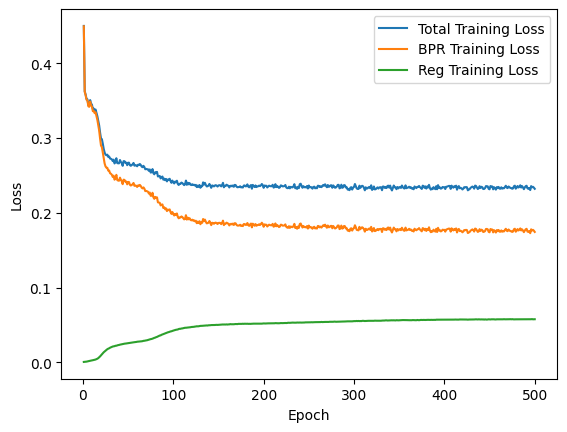

In [104]:
plt.plot(epoch_list, light_loss, label='Total Training Loss')
plt.plot(epoch_list, light_bpr, label='BPR Training Loss')
plt.plot(epoch_list, light_reg, label='Reg Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

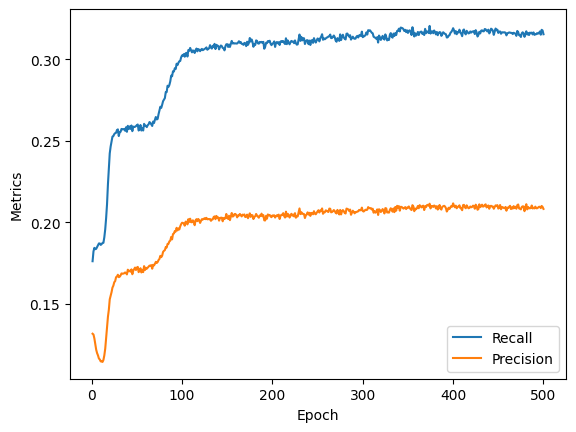

In [105]:
plt.plot(epoch_list, light_recall, label='Recall')
plt.plot(epoch_list, light_precision, label='Precision')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()

### Model performance

In [106]:
max(light_precision), max(light_recall)

(0.2117, 0.3206)